# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

## Table of Contents

<ul>
<li><a href="#load-data">Step 0: Load the Data</a></li>
<li><a href="#preprocessing">Step 1: Preprocessing</a></li>
    <ul>
        <li><a href="#assess-missing">1.1: Assess Missing Data</a></li>
        <li><a href="#re-encode">1.2: Select and Re-Encode Features</a></li>
        <li><a href="#clean-func">1.3: Create a Cleaning Function</a></li>
    </ul>
<li><a href="#feat_tran">Step 2: Feature Transformation</a></li>
    <ul>
        <li><a href="#feat_scale">2.1: Apply Feature Scaling</a></li>
        <li><a href="#dim-reduct">2.2: Perform Dimensionality Reduction</a></li>
        <li><a href="#int-pc">2.3: Interpret Principal Components</a></li>
    </ul>
<li><a href="#clustering">Step 3: Clustering</a></li>
    <ul>
        <li><a href="#gen-pop">3.1: Apply Clustering to General Population</a></li>
        <li><a href="#all-steps">3.2: Apply All Steps to the Customer Data</a></li>
        <li><a href="#compare-data">3.3: Compare Customer Data to Demographics Data</a></li>
    </ul>
</ul>

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import Imputer  ## Uncomment if scikit-learn v 0.19 or prior
from sklearn.impute import SimpleImputer     ## Uncomment if scikit-learn v 0.20 or later
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data <a id='load-data'></a>

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
# look at the string object columns
azdias[['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']].head()

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43


These columns encode the data with alpha-numeric values. There are a couple columns which have values that aren't immediately apparent why they are alpha-numeric. Below shows the values used in these columns:

In [8]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3', 'X'],
      dtype=object)

In [9]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

These columns use `"X"` or `"XX"` for some entries.

In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


**What values are used to indicate missing or unknown values?**

In [12]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

The values of `"X"` or `"XX"` found above are used to indicate missing or unknown values in the data set, as well as the digits `-1`, `0`, and `9` in some columns.

## Step 1: Preprocessing <a id='preprocessing'></a>

### Step 1.1: Assess Missing Data <a id='assess-missing'></a>

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Parse columns to replace data encoded as an missing or unknown with a NaN value
for col in azdias.columns:
    # extract missing or unknown label from `feat_info`
    mu_values = feat_info[feat_info['attribute'] == col]['missing_or_unknown'].values[0]
    # convert string to list of values
    mu_values = mu_values.strip('[]').split(',')
    # convert numeric values to ints, leaving strings as strings
    mu_values = [int(x) if x.lstrip('-').isnumeric() else x for x in mu_values]
    
    # replace value indicating missing or unknown with a NaN value
    azdias[col].replace(mu_values, np.nan, inplace=True)

In [14]:
# Review dataframe info to see if there are more null values than before
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Find number of null values in each column
# Sorted by number of null values in each column
azdias.isna().sum().value_counts().sort_index()

0         24
2881       1
4854       6
18348      1
73499      4
73969      1
77792      2
93148      4
93155      1
93740      3
94572      1
97008      1
97274      1
97375      2
97632      1
99352      3
99611      1
105800     1
108164     1
108315     1
111196     3
116515     7
133324     6
147988     1
158064     2
310267     1
392318     1
476524     1
584612     1
685843     1
889061     1
dtype: int64

There are some columns with no missing data and some columns with hundreds of thousands of missing values. What is the distribution of these columns?

In [16]:
def missing_vals_hist(df, df_name=None, axis=0, bins=20):
    """
    Determines the number of null values in a column or row and
    displays a histogram of results
    
    ARGS:
        df: dataframe object
        df_name: String name of dataframe
        axis: 0 for column, 1 for row
        bins: number of bins in histogram
    
    RETURN:
        none 
    """
    # Find null values
    null_series = df.isna().sum(axis=axis)
    
    # Generate histogram
    plt.hist(null_series, bins=bins)
    
    # Check if name string inclueded in args
    if df_name:
        plt.title(f'Missing Data in {df_name} DataFrame')
    else:
        plt.title(f'Missing Data in DataFrame')
    plt.xlabel('Missing values')
    # Correctly display 'row/column' depending on axis
    if axis == 0:
        plt.ylabel('Number of columns')
    elif axis == 1:
        plt.ylabel('Number of rows');

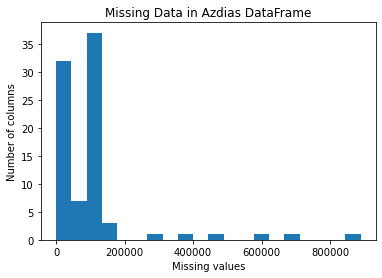

In [17]:
# Investigate patterns in the amount of missing data in each column.

# Histogram of the amount of missing values per column
missing_vals_hist(azdias, 'Azdias')

There are 6 columns with missing values exceeding 200,000 values.

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Find columns with more than 200,000 null values
null_cols = azdias.isna().sum()
null_cols = null_cols[null_cols > 200000].index

In [19]:
# This is needed for the "clean_data()" function later in the notebook
null_cols

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [20]:
# Drop columns with excessive null values
azdias.drop(null_cols, axis=1, inplace=True)

In [21]:
# Removes entries from feat_info that describe cols removed from azdias
# This is important for later steps, but feat_needs preserved for clean_data()

# Copy feat_info
feat_info_reduced = feat_info.copy()

# Remove rows corresponding to removed columns
for col in null_cols:
    feat_info_reduced = feat_info_reduced[feat_info_reduced['attribute'] != col]

**Re-vist missing value investigation**

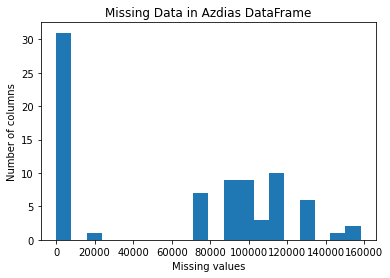

In [22]:
# Investigate patterns in the amount of missing data in each column.

# Histogram of the amount of missing values per column
missing_vals_hist(azdias, 'Azdias')

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are now no more outlier columns in terms of missing data. There are over 30 columns with no missing data and a cluster of columns with missing values between 70,000 and 160,000 values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?

# Find number of null values in each column
# Sorted by number of null values in each row
azdias.isna().sum(axis=1).value_counts().sort_index()

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

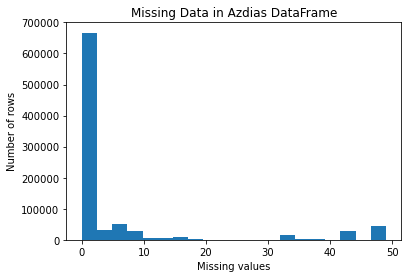

In [24]:
# Histogram of the amount of missing values per row
missing_vals_hist(azdias, 'Azdias', axis=1)

There are 2 clusters of row based on missing values: one group with fewer than 20 missing values, the other group with greater than 30 missing values. However, the histogram doesn't show exactly where the one group ends and the other begins. Here's a histogram zoomed in to show the number of rows with fewer than 3500 missing values easier:

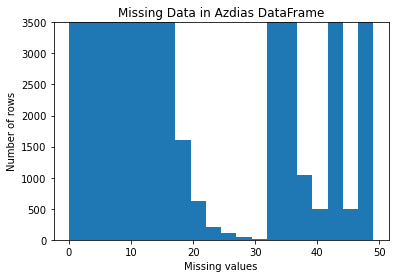

In [25]:
# Histogram of the amount of missing values per row
missing_vals_hist(azdias, 'Azdias', axis=1)

# Limit the y-axis to under 3500
plt.ylim(0,3500);

The two groups separate at around 30 missing values. This is where the data set will be divided: one with fewer than 30 missing values and one with 30 or greater missing values.

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

under_30_nans = azdias[azdias.isna().sum(axis=1) < 30].copy()
over_30_nans = azdias[azdias.isna().sum(axis=1) >= 30].copy()

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Five columns with little to no missing data

cols = ['FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'SEMIO_FAM', 'ZABEOTYP', 'ONLINE_AFFINITAET']

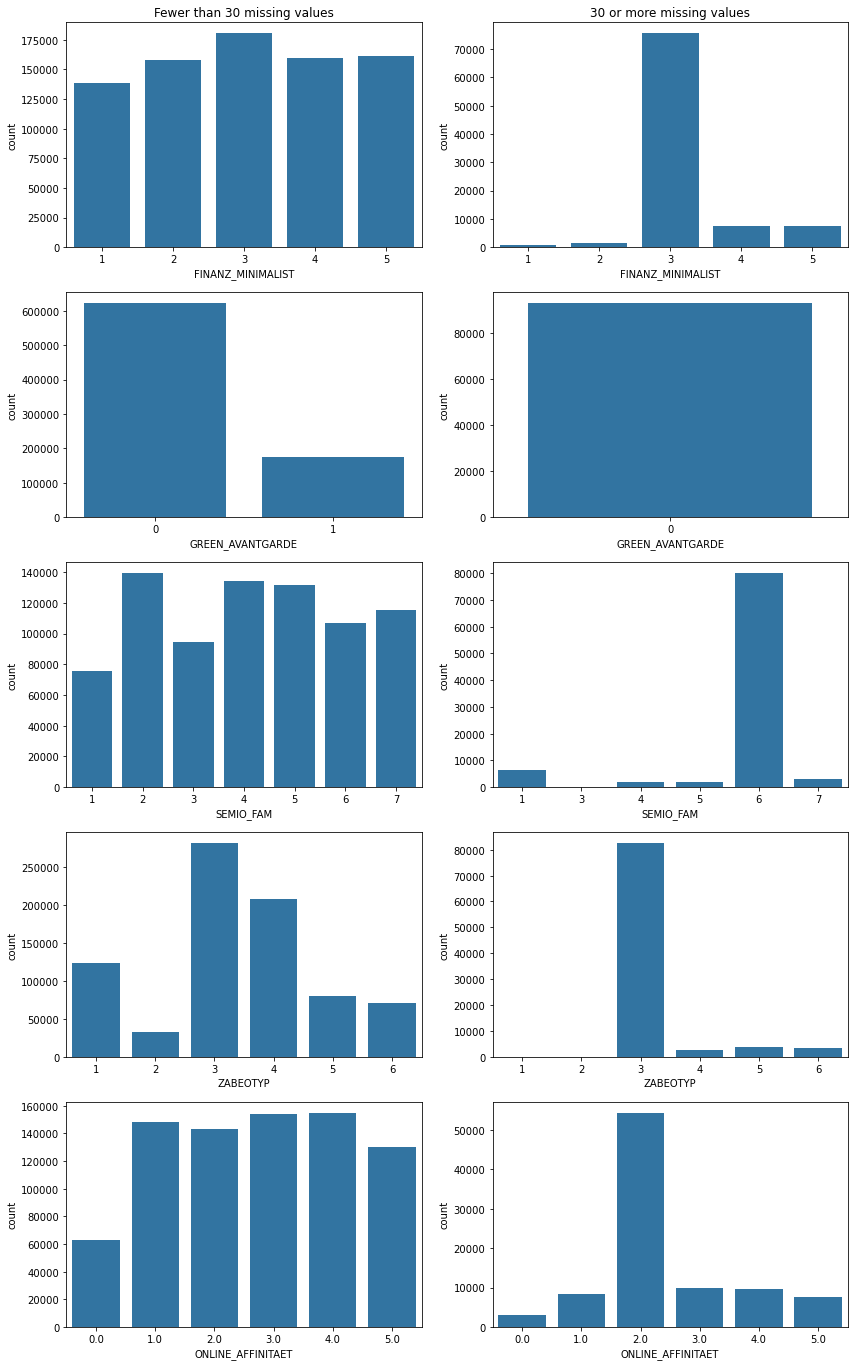

In [28]:
fig, ax = plt.subplots(5, 2, figsize=(14,24))

ax_row = 0

for col in cols:
    if ax_row == 0:
        sns.countplot(
            under_30_nans[col], ax=ax[ax_row, 0], color='#1f77b4'
        ).set_title('Fewer than 30 missing values')
        
        sns.countplot(
            over_30_nans[col], ax=ax[ax_row, 1], color='#1f77b4'
        ).set_title('30 or more missing values')
    else:
        sns.countplot(under_30_nans[col], ax=ax[ax_row, 0], color='#1f77b4')
        sns.countplot(over_30_nans[col], ax=ax[ax_row, 1], color='#1f77b4')
    ax_row += 1



plt.show();

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the above analysis, it is clear that rows with few or no missing values have a different distribution of values on columns with little or no missing data. The rows with little missing data has a wide distrubution of values while the rows with more missing data tends to have distributions that heavily favor one attribute.

This shows that the rows with more missing data could be fundamentally different than the rows with less missing data. Dropping these rows may have an impact on the final analysis.

### Step 1.2: Select and Re-Encode Features <a id='re-encode'></a>

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
feat_info_reduced['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables, or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_cols = feat_info_reduced[feat_info_reduced['type'] == 'categorical']['attribute']


for col in cat_cols:
    print(col)
    print(under_30_nans[col].unique())
    print('\n')

ANREDE_KZ
[2 1]


CJT_GESAMTTYP
[ 5.  3.  2.  4.  1.  6. nan]


FINANZTYP
[1 6 5 2 4 3]


GFK_URLAUBERTYP
[10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]


GREEN_AVANTGARDE
[0 1]


LP_FAMILIE_FEIN
[ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]


LP_FAMILIE_GROB
[ 3.  1. nan  5.  2.  4.]


LP_STATUS_FEIN
[ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]


LP_STATUS_GROB
[ 1.  2.  4.  5.  3. nan]


NATIONALITAET_KZ
[ 1.  3.  2. nan]


SHOPPER_TYP
[ 3.  2.  1.  0. nan]


SOHO_KZ
[1. 0.]


VERS_TYP
[ 2.  1. nan]


ZABEOTYP
[5 3 4 1 6 2]


GEBAEUDETYP
[8. 1. 3. 2. 6. 4. 5.]


OST_WEST_KZ
['W' 'O']


CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' nan '3']


CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']




### Categoric Features

| **Column** | **Level** | **DataType** | **Keep** |
| :--------: | :-------: | :----------: | :------: |
| ANREDE_KZ | Binary | Numeric | Yes |
| GREEN_AVANTGARDE | Binary | Numeric | Yes |
| SOHO_KZ | Binary | Numeric | Yes |
| VERS_TYP | Binary | Numeric | Yes |
| OST_WEST_KZ | Binary | String | Yes |
| CJT_GESAMTTYP | Multi-Level (6) | Numeric | Yes |
| FINANZTYP | Multi-Level (6) | Numeric | Yes |
| GFK_URLAUBERTYP | Multi-Level (12) | Numeric | Yes |
| LP_FAMILIE_FEIN | Multi-Level (11) | Numeric | Yes |
| LP_FAMILIE_GROB | Multi-Level (5) | Numeric | Yes |
| LP_STATUS_FEIN | Multi-Level (10) | Numeric | Yes |
| LP_STATUS_GROB | Multi-Level (5) | Numeric | Yes |
| NATIONALITAET_KZ | Multi-Level (3) | Numeric | Yes |
| SHOPPER_TYP | Multi-Level (4) | Numeric | Yes |
| ZABEOTYP | Multi-Level (6) | Numeric | Yes |
| GEBAEUDETYP | Multi-Level (7) | Numeric | Yes |
| CAMEO_DEUG_2015 | Multi-Level (9) | Numeric (As Str) | Yes |
| CAMEO_DEU_2015 | Multi-Level (44) | String | No |

In order to keep as much data as possible, only `CAMEO_DEU_2015` will be dropped. That column is a more detailed description on what is already encoded in `CAMEO_DEUG_2015`. These columns indicate the class the individual is in and it would be expected that they are highly correlated with each other. It shouldn't affect the analysis much if this detailed view of class is dropped because it is already contained in a broader sense in another column.

If the rest of the multi-level categorical are one-hot encoded it would result in a dataframe with just over 150 columns, which is large but not unweildy yet, especially since the dimensionality will be reduced in future steps. 

In [31]:
# drop  CAMEO_DEU_2015 column
under_30_nans.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [32]:
# Re-encode str binary column to numeric
under_30_nans['OST_WEST_KZ'] = under_30_nans['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [33]:
# Gather remiaing categorical columns in lis
ohe_cats = ['CJT_GESAMTTYP',
            'FINANZTYP',
            'GFK_URLAUBERTYP',
            'LP_FAMILIE_FEIN',
            'LP_FAMILIE_GROB',
            'LP_STATUS_FEIN',
            'LP_STATUS_GROB',
            'NATIONALITAET_KZ',
            'SHOPPER_TYP',
            'ZABEOTYP',
            'GEBAEUDETYP',
            'CAMEO_DEUG_2015']

In [34]:
# One-hot encode columns
under_30_dummies = pd.get_dummies(under_30_nans, columns=ohe_cats)

#### Discussion 1.2.1: Re-Encode Categorical Features

To keep as much information in the dataset, very few features were removed. The only features removed were features that had many categories that were also contained in another feature with the similar but broader categories. The binary category with strings as elements rather than numbers was reincoded with 0 and 1 in place of the strings. Then the multi-level categories that were kept were one-hot encoded.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Assess mixed variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_cols = feat_info_reduced[feat_info_reduced['type'] == 'mixed']['attribute']


for col in cat_cols:
    print(col)
    print(under_30_nans[col].unique())
    print('\n')

LP_LEBENSPHASE_FEIN
[21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13. 18.
 31. 38. 35. 30.  7. 22. 14. 29. 24. 28. 37. 26. 39. 27. 36.  9. 34. 33.
 15. 40. 16. 19. 17.]


LP_LEBENSPHASE_GROB
[ 6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  4.  8.]


PRAEGENDE_JUGENDJAHRE
[14. 15.  8.  3. 10. 11.  5.  9.  6.  4. nan  2.  1. 12. 13.  7.]


WOHNLAGE
[4. 2. 7. 3. 5. 1. 8. 0.]


CAMEO_INTL_2015
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']


PLZ8_BAUMAX
[ 1.  2. nan  4.  5.  3.]




### Mixed Features

| **Column** | **Level** | **DataType** | **Keep** |
| :--------: | :-------: | :----------: | :------: |
| LP_LEBENSPHASE_FEIN | Multi-Level (40) | Numeric | No |
| LP_LEBENSPHASE_GROB | Multi-Level (12) | Numeric | Yes |
| PRAEGENDE_JUGENDJAHRE | Multi-Level (6) | Numeric | Yes |
| WOHNLAGE | Multi-Level (6) | Numeric | Yes |
| CAMEO_INTL_2015 | Multi-Level (6) | Numeric (As Str) | Yes |
| PLZ8_BAUMAX | Multi-Level (6) | Numeric | Yes |

Just like `CAMEO_DEU_2015` and `CAMEO_DEUG_2015` above, `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` are fine and broad categories describing the same thing -- "Life Stage". `LP_LEBENSPHASE_FEIN` can be dropped with minimal loss of information. `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` will be broken down into separate columns, separating the mixed information into separate columns. After this, all the remaining columns need to be one-hot encoded. The final dataframe should have fewer than 200 columns after all the data engineering is complete, which is still a managable number of columns.

In [36]:
# Drop LP_LEBENSPHASE_FEIN column
under_30_dummies.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_map = {1.0: '40s',
              2.0: '40s',
              3.0: '50s',
              4.0: '50s',
              5.0: '60s',
              6.0: '60s',
              7.0: '60s',
              8.0: '70s',
              9.0: '70s',
              10.0: '80s',
              11.0: '80s',
              12.0: '80s',
              13.0: '80s',
              14.0: '90s',
              15.0: '90s'
}

under_30_dummies['PRAEGENDE_JUGENDJAHRE_DECADE'] = under_30_dummies['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

youth_map = {1.0: 0,
              2.0: 1,
              3.0: 0,
              4.0: 1,
              5.0: 0,
              6.0: 1,
              7.0: 1,
              8.0: 0,
              9.0: 1,
              10.0: 0,
              11.0: 1,
              12.0: 0,
              13.0: 1,
              14.0: 0,
              15.0: 1
}

under_30_dummies['PRAEGENDE_JUGENDJAHRE_YOUTH'] = under_30_dummies['PRAEGENDE_JUGENDJAHRE'].map(youth_map)

In [38]:
# Convert values to int - need to replace nan with 0 first
under_30_dummies['CAMEO_INTL_2015'].fillna(0, inplace=True)
under_30_dummies['CAMEO_INTL_2015'] = under_30_dummies['CAMEO_INTL_2015'].astype('int64')

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Tens place indicates wealth
under_30_dummies['CAMEO_INTL_2015_WEALTH'] = under_30_dummies['CAMEO_INTL_2015'] // 10
# Ones place indicates life stage
under_30_dummies['CAMEO_INTL_2015_STAGE'] = under_30_dummies['CAMEO_INTL_2015'] % 10

#### Discussion 1.2.2: Engineer Mixed-Type Features

The mixed features were handled in a very similar way to the categorical features in the previous step. Only the features with categories basically duplicated more broadly in another feature were dropped.

There were two features, `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`, that had a mix of features encoded in the one feature. These were each broken up into two different features to properly encode those features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Columns to One-hot encode
ohe_cats = ['LP_LEBENSPHASE_GROB',
              'PRAEGENDE_JUGENDJAHRE_DECADE',
              'WOHNLAGE',
              'CAMEO_INTL_2015_WEALTH',
              'CAMEO_INTL_2015_STAGE',
              'PLZ8_BAUMAX']

In [41]:
# One-hot encode final columns
under_30_dummies = pd.get_dummies(under_30_dummies, columns=ohe_cats)

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop unnecissary columns
under_30_dummies.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function <a id='clean-func'></a>

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    ########################################################
    # Put in code here to execute all main cleaning steps: #
    ########################################################
    
    # Import feature info df so this function works independently from prior code
    feat_df = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # convert missing value codes into NaNs, ...
    for col in df.columns:
        # extract missing or unknown label from `feat_info`
        mu_values = feat_df[feat_df['attribute'] == col]['missing_or_unknown'].values[0]
        # convert string to list of values
        mu_values = mu_values.strip('[]').split(',')
        # convert numeric values to ints, leaving strings as strings
        mu_values = [int(x) if x.lstrip('-').isnumeric() else x for x in mu_values]

        # replace value indicating missing or unknown with a NaN value
        df[col].replace(mu_values, np.nan, inplace=True)
    
    #########################################
    # remove selected columns and rows, ... #
    #########################################
    
    # Columns with more than 200,000 null values in original data
    null_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    # Drop columns with excessive null values
    df.drop(null_cols, axis=1, inplace=True)
    
    # Remove rows with 30 or more null values
    df = df[df.isna().sum(axis=1) < 30].copy()
    
    df.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    
    ##################################################
    # select, re-encode, and engineer column values. #
    ##################################################
    
    # Re-encode str binary column to numeric
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Categorical columns to one-hot enco
    ohe_cats = ['CJT_GESAMTTYP',
            'FINANZTYP',
            'GFK_URLAUBERTYP',
            'LP_FAMILIE_FEIN',
            'LP_FAMILIE_GROB',
            'LP_STATUS_FEIN',
            'LP_STATUS_GROB',
            'NATIONALITAET_KZ',
            'SHOPPER_TYP',
            'ZABEOTYP',
            'GEBAEUDETYP',
            'CAMEO_DEUG_2015']
    
    # One-hot encode columns
    df = pd.get_dummies(df, columns=ohe_cats)
    
    # Drop LP_LEBENSPHASE_FEIN column
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    # Separate "PRAEGENDE_JUGENDJAHRE" into two new variables.
    decade_map = {1.0: '40s',
                  2.0: '40s',
                  3.0: '50s',
                  4.0: '50s',
                  5.0: '60s',
                  6.0: '60s',
                  7.0: '60s',
                  8.0: '70s',
                  9.0: '70s',
                  10.0: '80s',
                  11.0: '80s',
                  12.0: '80s',
                  13.0: '80s',
                  14.0: '90s',
                  15.0: '90s'
    }

    youth_map = {1.0: 0,
                 2.0: 1,
                 3.0: 0,
                 4.0: 1,
                 5.0: 0,
                 6.0: 1,
                 7.0: 1,
                 8.0: 0,
                 9.0: 1,
                 10.0: 0,
                 11.0: 1,
                 12.0: 0,
                 13.0: 1,
                 14.0: 0,
                 15.0: 1
    }
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    df['PRAEGENDE_JUGENDJAHRE_YOUTH'] = df['PRAEGENDE_JUGENDJAHRE'].map(youth_map)
    
    # Separate "CAMEO_INTL_2015" into two new variables.
    # Convert values to int - need to replace nan with 0 first
    df['CAMEO_INTL_2015'].fillna(0, inplace=True)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int64')
    
    # Tens place indicates wealth
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'] // 10
    # Ones place indicates life stage
    df['CAMEO_INTL_2015_STAGE'] = df['CAMEO_INTL_2015'] % 10
    
    # Mixed columns to One-hot encode
    ohe_cats = ['LP_LEBENSPHASE_GROB',
                'PRAEGENDE_JUGENDJAHRE_DECADE',
                'WOHNLAGE',
                'CAMEO_INTL_2015_WEALTH',
                'CAMEO_INTL_2015_STAGE',
                'PLZ8_BAUMAX'
               ]
    
    # One-hot encode final columns
    df = pd.get_dummies(df, columns=ohe_cats)
    
    # Drop unnecissary columns
    df.drop(
        ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'],
        axis=1, inplace=True
    )

    #################################
    # Return the cleaned dataframe. #
    #################################
    
    return df

## Step 2: Feature Transformation <a id='feat_tran'></a>

### Step 2.1: Apply Feature Scaling <a id='feat_scale'></a>

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

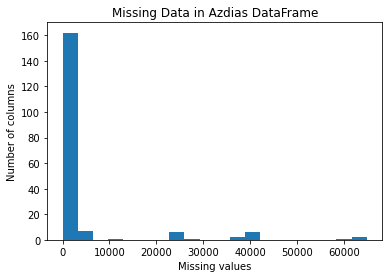

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# View amount of columns with missing data
missing_vals_hist(under_30_dummies, 'Azdias')

Most columns now have few to zero missing values. There are still some that have significant amounts of missing values, though.

In [45]:
# Uncomment and comment below cell if using sklearn 0.19 or lower

# # Instatiate
# imputer = SimpleImputer()

# # Fit and transform
# imputed = imputer.fit_transform(under_30_dummies)

In [46]:
# Keep uncommented if using sklearn 0.20 or higher

# Instatiate
imputer = SimpleImputer()

# Fit and transform
imputed = imputer.fit_transform(under_30_dummies)

In [47]:
azdias_imp = pd.DataFrame(imputed, columns=under_30_dummies.columns)

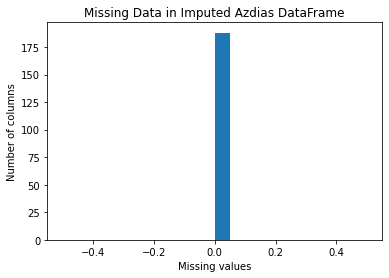

In [48]:
missing_vals_hist(azdias_imp, 'Imputed Azdias')

In [49]:
# Apply feature scaling to the general population demographics data.

# Instatiate
scaler = StandardScaler()

# Fit and transform
scaled = scaler.fit(azdias_imp)
scaled_transform = scaled.transform(azdias_imp)

In [50]:
# Put scaled values back into a dataframe
azdias_scaled = pd.DataFrame(scaled_transform, columns=azdias_imp.columns)

### Discussion 2.1: Apply Feature Scaling

Null values were converted to numeric values by using sklear's imputer class. The default parameter for this imputation was kept, so the method to fill the missing values was the mean of the other values. This was done to refrain from overrepresenting values by using the mode. These values filled with the mean should have the least affect on the next steps. Standard Scaling was done to scale the data so the mean is 0 and standard deviation is 1. This will keep the features with a high variance from having an outsized influence.

### Step 2.2: Perform Dimensionality Reduction <a id='dim-reduct'></a>

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.

# Instatiate
pca_all = PCA(random_state=42)

# Fit & Transform
azdias_fit = pca_all.fit(azdias_scaled)
azdias_trans = pca_all.transform(azdias_scaled)

In [52]:
# Investigate the variance accounted for by each principal component.

# Define variace plot function
def var_plot(pca, scree=True):
    """
    Function takes a data frame and pca value and generates a plot
    to show variane accounted for by principle components.
    
    ARGS:
        pca: PCA object
        scree: True for scree plot, False for simple bar graph
    
    RETURN:
        none 
    """
    
    var_ratio = pca.explained_variance_ratio_
    num_components = np.arange(len(var_ratio))
    cum_vals = np.cumsum(var_ratio)

    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)

    ax.bar(num_components, var_ratio)
    if scree:
        ax.plot(num_components, cum_vals)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

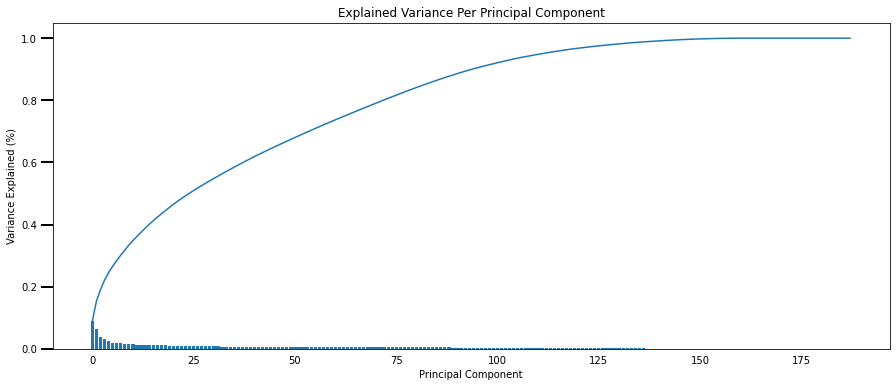

In [53]:
# Scree chart showing variance of PCA transformation with no paramaters
var_plot(pca_all)

This scree plot isn't very helpful to determine how many principal components are needed. Here is just the bar chart portion of the graph:

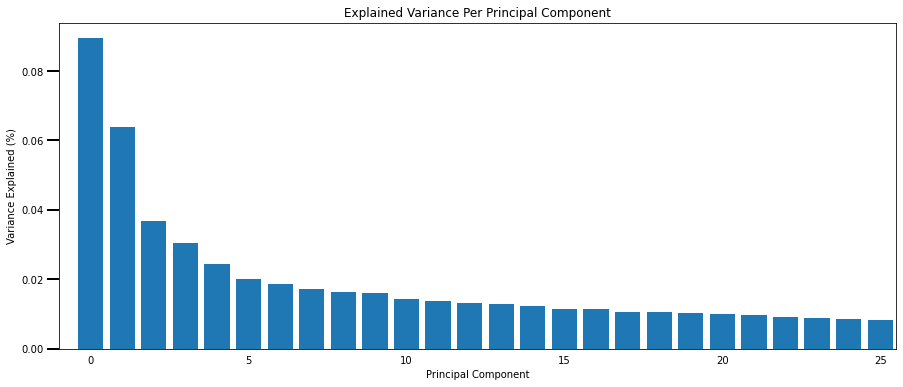

In [54]:
# Bar chart showing variance of PCA transformation with no paramaters
var_plot(pca_all, scree=False)

# Restrict the x-axis to allow a better view of the important data
plt.xlim(-1,25.5);

This chart is more helpful. There is a large amount of variance, comparatively, for the first 5 principal components, and possibly a siginficant amount of varance accounted for over the next 5-10 components, but it is hard to tell. Using 5, 10, or 15 principal components would be helpful to retain. Retaining any more than that is unlikely to make much of a difference.

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.

# 5 Principal Components

# Instatiate
pca_5 = PCA(5, random_state=42)

# Fit & Transform
azdias_fit_5 = pca_5.fit(azdias_scaled)
azdias_trans_5 = pca_5.transform(azdias_scaled)

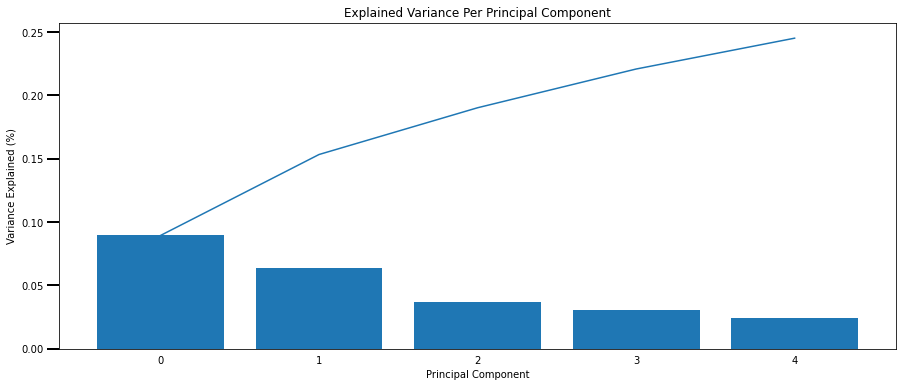

In [56]:
# Scree chart showing variance of PCA transformation with 5 principal components

var_plot(pca_5)

In [57]:
# Total percentage of 5 principal components
pca_5.explained_variance_ratio_.sum()

0.24521617780383587

5 principal components are responsible for nearly 25% of the model's variance.

In [58]:
# 10 Principal Components

# Instatiate
pca_10 = PCA(10, random_state=42)

# Fit & Transform
azdias_fit_10 = pca_10.fit(azdias_scaled)
azdias_trans_10 = pca_10.transform(azdias_scaled)

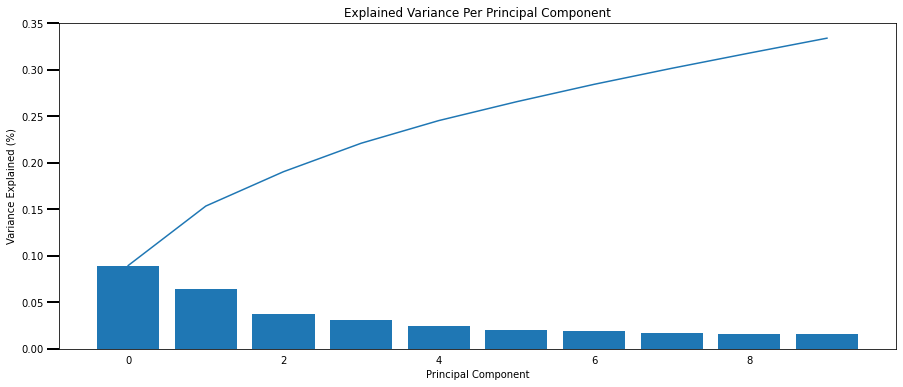

In [59]:
# Scree chart showing variance of PCA transformation with 10 principal components
var_plot(pca_10)

In [60]:
# Total percentage of 10 principal components
pca_10.explained_variance_ratio_.sum()

0.3337738405161684

In [61]:
# 15 Principal Components

# Instatiate
pca_15 = PCA(15, random_state=42)

# Fit & Transform
azdias_fit_15 = pca_15.fit(azdias_scaled)
azdias_trans_15 = pca_15.transform(azdias_scaled)

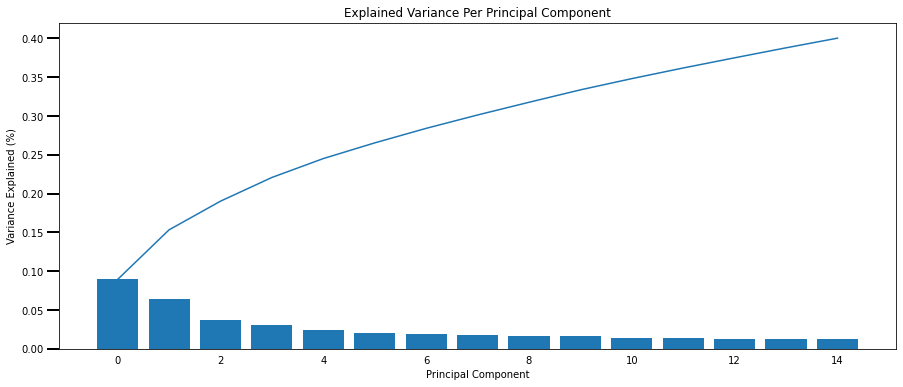

In [62]:
# Scree chart showing variance of PCA transformation with 15 principal components
var_plot(pca_15)

In [63]:
# Total percentage of 15 principal components
pca_15.explained_variance_ratio_.sum()

0.4004000666071043

Expanding to 10 or 15 principal components explains for about an additional 15% more.

### Discussion 2.2: Perform Dimensionality Reduction

 It's difficult to tell how many principal components are needed. Approaching 15, there doesn't seem to be much increase per component, but there are large increases in variance over the first 5 components. It feels like 10 principal components may be a good threshold to preserve as much information while keeping the analysis manageable.

### Step 2.3: Interpret Principal Components <a id='int-pc'></a>

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [64]:
# Define a function to map principle component weights
def map_weights(df, pca, component, num_components=10):
    """
    Takes a dataframe and a pca transformation of that df
    and returns the N most interesting features of a selected
    principal component sorted by importance
    
    ARGS:
        df: DataFrame object
        pca: PCA object - transformation of above df
        component: the principle component number (0-indexed)
        num_components: number of components to return
    
    RETURN:
        dataframe object of top N most interesting features
    """
    
    # load components in df
    components = pca.components_[component]
    component_df = pd.DataFrame(components, index=azdias_scaled.columns, columns=['weight'])
    # add absolute value column to sort values on
    component_df['abs_weight'] = np.abs(component_df['weight'])
    # sort by abs_weight column
    component_df.sort_values(by=['abs_weight'], ascending=False, inplace=True)
    
    # create df of most important features
    important_df = component_df[['weight']].head(num_components)
    
    # return df
    return important_df

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

first_component = map_weights(azdias_scaled, pca_10, 0)
first_component

,weight
MOBI_REGIO,-0.195370
LP_STATUS_GROB_1.0,0.186800
KBA05_ANTG1,-0.182541
FINANZ_MINIMALIST,-0.179095
PLZ8_ANTG3,0.178832
PLZ8_ANTG1,-0.178755
HH_EINKOMMEN_SCORE,0.174634
KBA05_GBZ,-0.173838
PLZ8_ANTG4,0.173028
PLZ8_BAUMAX_1.0,-0.167381


The most interesting features for the first principal component are:

| **Negative weight** | **Positive Weight** |
| :-----------------: | :-----------------: |
| Movement patterns (High to Low) | Social Status (Low-Income Earners) |
| Number of 1-2 family houses in the microcell (Low to High) | Number of 6-10 family houses in the PLZ8 region (Low to High) |
| Low Financial interest (Low to High) | Estimated HH net income (High to Low) |
| Number of 1-2 family houses in the PLZ8 region (Low to High) | Number of 10+ family houses in the PLZ8 region (Low to High) |
| Number of buildings in the microcell (Low to High) |  |
| PLZ8 region mainly 1-2 family houses |  |

This first principle component holds that an individual with a high movement pattern is less likely to live in an area primaily of 1-2 family houses. As movement patterns increase, financial interest decreases.

At the same time, low income earners are more likely to live in areas with high amounts of multi-family houses.

This seems to show that more movement (therefore less stability of "putting down roots") is associated with lower income and a greater need for shared housing.

In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_component = map_weights(azdias_scaled, pca_10, 1)
second_component

,weight
ALTERSKATEGORIE_GROB,0.225905
FINANZ_SPARER,-0.225345
FINANZ_VORSORGER,0.216792
FINANZ_UNAUFFAELLIGER,-0.212275
SEMIO_REL,-0.203825
FINANZ_ANLEGER,-0.201449
PRAEGENDE_JUGENDJAHRE_DECADE_90s,-0.200873
SEMIO_TRADV,-0.200824
SEMIO_PFLICHT,-0.198384
ZABEOTYP_3,0.192257


The most interesting features for the second principal component are:

| **Negative weight** | **Positive Weight** |
| :-----------------: | :-----------------: |
| Money-Saver (High to Low) | Estimated age based on given name (Young to Old) |
| Inconspicuous Financially (High to Low) | "Be Prepared" Financial Mentality (High to Low) |
| Religious (High to Low) | Fair supplied Energy Consumption |
| Investor (High to Low) |  |
| 90s Child |  |
| Traditionally-minded (High to Low) |  |
| Dutiful personality (High to Low) |  |

The second principle component indicates a clustering that tends to indicate age and conservatism. As saving money increases, religious identity, interest in investing, traditional-mindedness, and sense of duty increases.

The positive weighs indicate this individual is likely older due to their given name, less likely to have a "be prepared" financial mentality, and care that their energy is fairly supplied.

In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_component = map_weights(azdias_scaled, pca_10, 2)
third_component

,weight
ANREDE_KZ,-0.337336
SEMIO_VERT,0.312387
SEMIO_KAEM,-0.306213
SEMIO_DOM,-0.272956
SEMIO_KRIT,-0.264038
SEMIO_FAM,0.259035
SEMIO_SOZ,0.253716
SEMIO_KULT,0.252247
SEMIO_ERL,-0.211068
FINANZ_ANLEGER,-0.146070


The most interesting features for the third principal component are:

| **Negative weight** | **Positive Weight** |
| :-----------------: | :-----------------: |
| Gender (Male or Female) | Dreamful (High to Low) |
| Combative Attitude (High to Low) | Family-Minded (High to Low) |
| Dominant-Minded (High to Low) | Socially-Minded (High to Low) |
| Critical-Minded (High to Low) | Culturally-Minded (High to Low) |
| Event-Oriented (High to Low) |  |
| Investor (High to Low) |  |

The third principle component shows the relationship between gender and personality type. A male is more likely to be combatitve, dominant or critical-minded, event oriented, and an investor.

Females, on the other hand, tend to be dreamful, as well as family, socially, and culturally-minded.

### Discussion 2.3: Interpret Principal Components

The first three principle components group the individuals by socio-economic status/housing needs, financial conservatism, and gender/personality. The first two components can help indicate *who* is a good target demographic to advertise to, and the third component can help indicate *how* to market to a demographic.

## Step 3: Clustering <a id='clustering'></a>

### Step 3.1: Apply Clustering to General Population <a id='gen-pop'></a>

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
# Over a number of different cluster counts...

mean_dist = []

for i in range(1,31):
    # run k-means clustering on the data and...
    
    # Instatiate
    kmeans_n = KMeans(n_clusters=i, random_state=42)
    
    # Fit & Transform
    kmeans_trans = kmeans_n.fit_transform(azdias_trans_10)
        
    # compute the average within-cluster distances.
    min_dist = []
    
    # Get distance to closest centroid
    for row in kmeans_trans:
        min_dist.append(np.min(row))
    
    # Add average distance to list
    mean_dist.append(np.mean(min_dist))

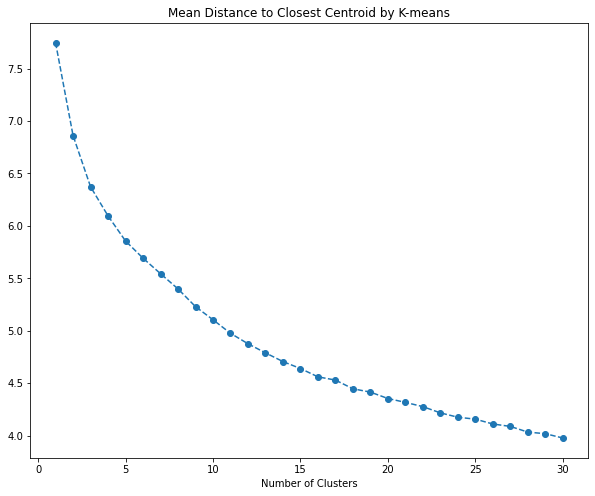

In [69]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10,8))
plt.plot(range(1,31), mean_dist, marker='o', linestyle='--')

plt.xlabel('Number of Clusters')
plt.title('Mean Distance to Closest Centroid')
plt.title('Mean Distance to Closest Centroid by K-means');

In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_10 = KMeans(n_clusters=10, random_state=42)
    
# Fit
kmeans_10_fit = kmeans_10.fit(azdias_trans_10)

# Predict
predictions = kmeans_10_fit.predict(azdias_trans_10)

### Discussion 3.1: Apply Clustering to General Population

Using the "elbow-method" can help determine the best number of clusters. However, there is no clear point where the elbow is found. Between 8 cluster and 9, there is a loss of net benefit, but ther is a sizable drop between 9 and 10 clusters. After 10 clusters, the net benefit does not increase as much for each successive cluster. K-means will then be fit with 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data <a id='all-steps'></a>

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [72]:
cust_size_before = customer.shape[0]

In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean customer df
customer_clean = clean_data(customer)

In [74]:
# Find the amount of rows that were deleted in cleaning
# This group of rows will be assumed to be another cluster

cust_size_after = customer_clean.shape[0]

In [75]:
customer_clean.shape

(141725, 187)

In [76]:
azdias_scaled.shape

(798061, 188)

There is one more column in Azdias than Customers. This will need corrected before running the transformations.

In [77]:
# Ensure dataframes have the same columns
# Find column in Azdias and not in Customers

for col in azdias_scaled.columns:
    if col not in customer_clean.columns:
        print(col)
        print(azdias_scaled.columns.get_loc(col))

GEBAEUDETYP_5.0
132


There is only one column in Azdias that is not in Customers. This means that there should not be any columns in Customers that do not exist in Azdias, since the number of extra columns in Azdias was equal to the difference in numbers of columns. This extra column will need added to Customers at the location it is in Azdias to ensure the transformations are able to be applied.

In [78]:
# Add GEBAEUDETYP_5.0 to customers_clean
customer_clean.insert(132, 'GEBAEUDETYP_5.0', 0)

In [79]:
# Apply feature transformation and clustering
customer_trans = imputer.transform(customer_clean)
customer_trans = scaler.transform(customer_trans)
customer_trans = pca_10.transform(customer_trans)

# Predict using K-means
customer_preds = kmeans_10_fit.predict(customer_trans)

### Step 3.3: Compare Customer Data to Demographics Data <a id='compare-data'></a>

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [80]:
# Get 11th cluster size from the general population
# and custmer datasets
pop_11th_cluster = over_30_nans.shape[0]
cust_11th_cluster = cust_size_before - cust_size_after

# Get total size of General and Customer datasets
pop_total = azdias_scaled.shape[0] + pop_11th_cluster
cust_total = cust_size_before

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Get number of datapoints in each cluster in the general population
pop_cluster_count = np.bincount(kmeans_10_fit.labels_)
# Add 11th cluster
pop_cluster_count = np.append(pop_cluster_count, pop_11th_cluster)
# Get proportion of datapoints in each cluster
pop_cluster_prop = pop_cluster_count / pop_total


# Get number of datapoints in each cluster in the customer data
cust_cluster_count = np.bincount(customer_preds)
# Add 11th cluster
cust_cluster_count = np.append(cust_cluster_count, cust_11th_cluster)
# Get proportion of datapoints in each cluster
cust_cluster_prop = cust_cluster_count / cust_total

In [82]:
# Combine into dataframe

# Proportions column
props = np.append(pop_cluster_prop, cust_cluster_prop)

# Grouping column
grouping = []

for i in range(22):
    if i < 11:
        grouping.append('population')
    else:
        grouping.append('customer')

# Cluster column
clust = np.append(np.arange(1,12), np.arange(1,12))

cluster_df = pd.DataFrame({'proportions': props, 'group': grouping, 'cluster':clust})

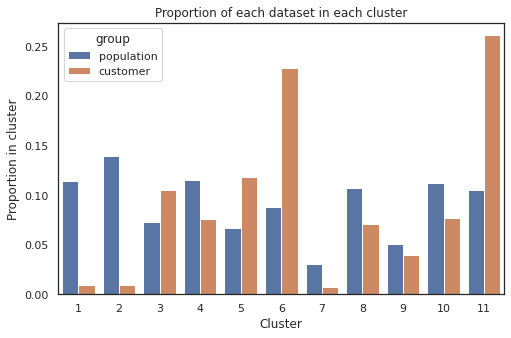

In [83]:
# Create visualization of cluster proportions
sns.set(rc={"figure.figsize":(8, 5)})
sns.set(style='white')

sns.barplot(data=cluster_df, x='cluster', y='proportions', hue='group')

plt.ylabel('Proportion in cluster')
plt.xlabel('Cluster')
plt.title('Proportion of each dataset in each cluster');

The 6th and 11th clusters are strongly overrpresented in the customer dataset. The 3rd and 5th clusters are also overrepresented by a smaller margin. Clusters 1, 2, and 7 are strongly underrepresented in the customer dataset.

In [84]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Find the weights associated with each principal component for the 6th cluster
kmeans_10.cluster_centers_[5]

array([-4.26221578,  0.7780072 ,  1.37296215,  2.95879059, -1.99762329,
       -0.26981379, -1.18189331, -0.86147042,  0.53631534, -0.75948081])

This cluster, the sixth cluster, has strong negative weights associated with the first principle component and positive weights associated with the second and third components. The first PC was positively weighted toward low income individuals living in areas with high amounts of shared housing. Since this cluster is negatively weighted, the inverse of this PC would be true, so the typical customer is higher income and lives in area mainly comprised of 1-2 family houses.

The second and third PCs have a positive weight, so the typical customer is also likely older, conservative, and male.

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Find the weights associated with each principal component for the 2nd cluster
kmeans_10.cluster_centers_[1]

array([ 5.54710947e+00, -2.47885580e+00, -6.49110825e-02,  2.76698905e-01,
       -2.80166391e-01, -2.05353015e-01,  4.25957632e-03, -1.10274476e+00,
       -3.44139175e-01,  5.56141593e-02])

The weights on this cluster (2) are the exact opposite directions and a higher magnitude than cluster 6. So an atypical customer would be one that is a younger female, not financially conservative, and lives in areas with few 1-2 family homes and a high concentration of 6+ family houses.

### Discussion 3.3: Compare Customer Data to Demographics Data

From comparing the customer clusters with what was discovered with the principle component analysis, the target demographic for the company is males who live primarily in areas with 1-2 family houses.